# File Info
Learns non-chaotic lorenz with $\rho(t)$ transitioning from 10 to 14 using piecewise neural odes. 

Uses a custom loss function which weights loss in each partition equally. L2 - moving partition

In [ ]:
# Import the necessary packages:\begin{frame}{How does RC work?}
    

from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

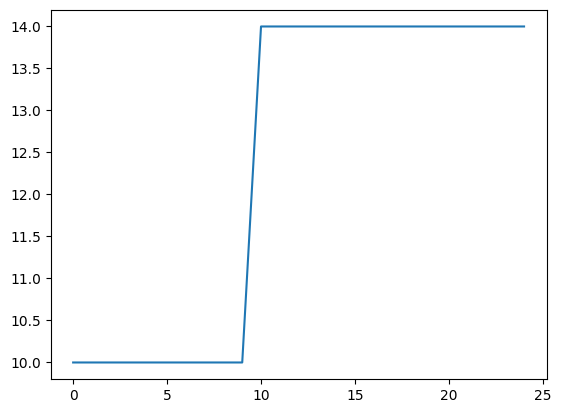

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [8]:
data_norm[0, :, 0, 0].shape

(300,)

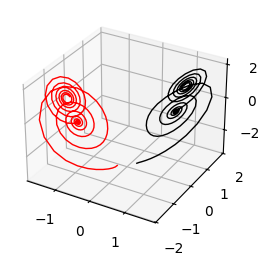

In [9]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

## Custom Loss function 

In [ ]:
class PiecewiseLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.L1Loss()

    def forward(self, input, target, breakpoints, time_tensor):
        index = torch.searchsorted(time_tensor, breakpoints)
        total_loss = 0.0
        for i in range(index.shape[0]-1):
            input_segment = input[:, index[i]:index[i+1]]
            target_segment = target[:, index[i]:index[i+1]]
            #print('input_segment.shape, target_segment.shape', input_segment.shape, target_segment.shape)
            segment_loss = self.loss_fn(input_segment, target_segment)
            total_loss += segment_loss
            
       

        return total_loss

## Model Setup 

In [95]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [96]:
#Saving loss and setting optimiser 
loss_list = []
breakpt_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [97]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [98]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [103]:
model.breakpoints[1] = torch.tensor(10.0

Parameter containing:
tensor([10.], requires_grad=True)

In [104]:
model.breakpoints[1] = torch.tensor(10.0)
model.break_params = nn.Parameter(torch.tensor([10.0], requires_grad=True))

In [109]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = PiecewiseLoss()
PiecewiseLoss.loss_fn = nn.MSELoss()
train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[i, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(92.4617, grad_fn=<AddBackward0>)
Gradient of Breakpoints: tensor([21.2976])



In [106]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(4.9445, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.7683])



## Main Training Loop

In [91]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [92]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [128]:
batch_length = 20
num_batch = 15
num_epochs = 1000
#Loss function will not scale to more time scales. piecewise loss function only takes one timescale. 

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float(), breakpoints=model.breakpoints, time_tensor=batch_time_i[0, :].float()) # Will not scale here 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[0, :].float()) # same issue here
                breakpt_list.append(model.break_params.item())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:02<49:29,  2.97s/it]

Epoch 0, Loss: 0.25875189900398254


  2%|▏         | 21/1000 [01:00<51:11,  3.14s/it]

Epoch 20, Loss: 0.12824365496635437


  4%|▍         | 41/1000 [02:10<51:32,  3.22s/it]  

Epoch 40, Loss: 0.12102781236171722


  6%|▌         | 61/1000 [03:06<43:46,  2.80s/it]

Epoch 60, Loss: 0.16171903908252716


  8%|▊         | 81/1000 [04:10<1:00:19,  3.94s/it]

Epoch 80, Loss: 0.11396966129541397


 10%|█         | 101/1000 [05:05<40:39,  2.71s/it] 

Epoch 100, Loss: 0.11278482526540756


 12%|█▏        | 121/1000 [06:58<1:37:22,  6.65s/it]

Epoch 120, Loss: 0.13958987593650818


 14%|█▍        | 141/1000 [08:46<1:16:04,  5.31s/it]

Epoch 140, Loss: 0.1674938201904297


 16%|█▌        | 161/1000 [10:33<1:17:57,  5.57s/it]

Epoch 160, Loss: 0.11015944182872772


 18%|█▊        | 181/1000 [12:23<1:16:29,  5.60s/it]

Epoch 180, Loss: 0.2546936273574829


 20%|██        | 201/1000 [14:00<1:05:25,  4.91s/it]

Epoch 200, Loss: 0.25287240743637085


 22%|██▏       | 221/1000 [15:42<1:07:26,  5.19s/it]

Epoch 220, Loss: 0.12171436846256256


 24%|██▍       | 241/1000 [17:26<55:19,  4.37s/it]  

Epoch 240, Loss: 0.12294059246778488


 26%|██▌       | 261/1000 [18:58<1:04:03,  5.20s/it]

Epoch 260, Loss: 0.1242968961596489


 28%|██▊       | 281/1000 [20:50<1:12:07,  6.02s/it]

Epoch 280, Loss: 0.2520151734352112


 30%|███       | 301/1000 [22:42<1:03:50,  5.48s/it]

Epoch 300, Loss: 0.2005266696214676


 32%|███▏      | 321/1000 [24:38<1:10:50,  6.26s/it]

Epoch 320, Loss: 0.11273075640201569


 34%|███▍      | 341/1000 [26:17<48:54,  4.45s/it]  

Epoch 340, Loss: 0.11256729066371918


 36%|███▌      | 361/1000 [28:00<54:30,  5.12s/it]  

Epoch 360, Loss: 0.11036224663257599


 38%|███▊      | 381/1000 [30:06<1:19:44,  7.73s/it]

Epoch 380, Loss: 0.2581717073917389


 40%|████      | 401/1000 [32:38<1:21:25,  8.16s/it]

Epoch 400, Loss: 0.10438646376132965


 42%|████▏     | 421/1000 [35:00<1:13:13,  7.59s/it]

Epoch 420, Loss: 0.10817968845367432


 44%|████▍     | 441/1000 [37:51<1:00:09,  6.46s/it]

Epoch 440, Loss: 0.09950003772974014


 46%|████▌     | 461/1000 [39:50<55:57,  6.23s/it]  

Epoch 460, Loss: 0.2678532600402832


 48%|████▊     | 481/1000 [42:05<59:21,  6.86s/it]  

Epoch 480, Loss: 0.1705915331840515


 50%|█████     | 501/1000 [44:23<55:20,  6.66s/it]  

Epoch 500, Loss: 0.11449820548295975


 52%|█████▏    | 521/1000 [46:32<49:27,  6.20s/it]

Epoch 520, Loss: 0.11055246740579605


 54%|█████▍    | 541/1000 [48:36<53:24,  6.98s/it]

Epoch 540, Loss: 0.211904838681221


 56%|█████▌    | 561/1000 [50:46<53:37,  7.33s/it]

Epoch 560, Loss: 0.27241235971450806


 58%|█████▊    | 581/1000 [52:56<47:31,  6.81s/it]

Epoch 580, Loss: 0.11230825632810593


 60%|██████    | 601/1000 [55:03<43:30,  6.54s/it]

Epoch 600, Loss: 0.23486176133155823


 62%|██████▏   | 621/1000 [57:15<45:23,  7.19s/it]

Epoch 620, Loss: 0.1349468231201172


 64%|██████▍   | 641/1000 [59:28<41:46,  6.98s/it]

Epoch 640, Loss: 0.21506549417972565


 66%|██████▌   | 661/1000 [1:01:53<44:13,  7.83s/it]

Epoch 660, Loss: 0.1408054679632187


 68%|██████▊   | 681/1000 [1:04:15<38:50,  7.30s/it]

Epoch 680, Loss: 0.11286896467208862


 70%|███████   | 701/1000 [1:06:41<35:07,  7.05s/it]

Epoch 700, Loss: 0.12549446523189545


 72%|███████▏  | 721/1000 [1:09:00<34:39,  7.45s/it]

Epoch 720, Loss: 0.2961810231208801


 74%|███████▍  | 741/1000 [1:11:34<34:05,  7.90s/it]

Epoch 740, Loss: 0.25651320815086365


 76%|███████▌  | 761/1000 [1:14:03<29:55,  7.51s/it]

Epoch 760, Loss: 0.12931618094444275


 78%|███████▊  | 781/1000 [1:16:40<22:54,  6.27s/it]

Epoch 780, Loss: 0.11948072165250778


 80%|████████  | 801/1000 [1:18:42<19:43,  5.95s/it]

Epoch 800, Loss: 0.3145797550678253


 82%|████████▏ | 821/1000 [1:20:35<17:00,  5.70s/it]

Epoch 820, Loss: 0.11881144344806671


 84%|████████▍ | 841/1000 [1:22:27<15:31,  5.86s/it]

Epoch 840, Loss: 0.11478596925735474


 86%|████████▌ | 861/1000 [1:24:15<13:34,  5.86s/it]

Epoch 860, Loss: 0.2823491394519806


 88%|████████▊ | 881/1000 [1:26:02<10:52,  5.49s/it]

Epoch 880, Loss: 0.10628338903188705


 90%|█████████ | 901/1000 [1:27:54<09:13,  5.59s/it]

Epoch 900, Loss: 0.12499941140413284


 92%|█████████▏| 921/1000 [1:29:46<07:58,  6.06s/it]

Epoch 920, Loss: 0.20342987775802612


 94%|█████████▍| 941/1000 [1:31:35<05:32,  5.63s/it]

Epoch 940, Loss: 0.1275034248828888


 96%|█████████▌| 961/1000 [1:33:25<03:36,  5.54s/it]

Epoch 960, Loss: 0.12324200570583344


 98%|█████████▊| 981/1000 [1:35:14<01:49,  5.79s/it]

Epoch 980, Loss: 0.120351642370224


100%|██████████| 1000/1000 [1:36:57<00:00,  5.82s/it]


## Plotting results

In [129]:
np.savetxt('PA_NODE_Bif_Lorenz_v4_adjlossL2.csv', np.array(loss_list))

Text(0.5, 0, 'Epochs')

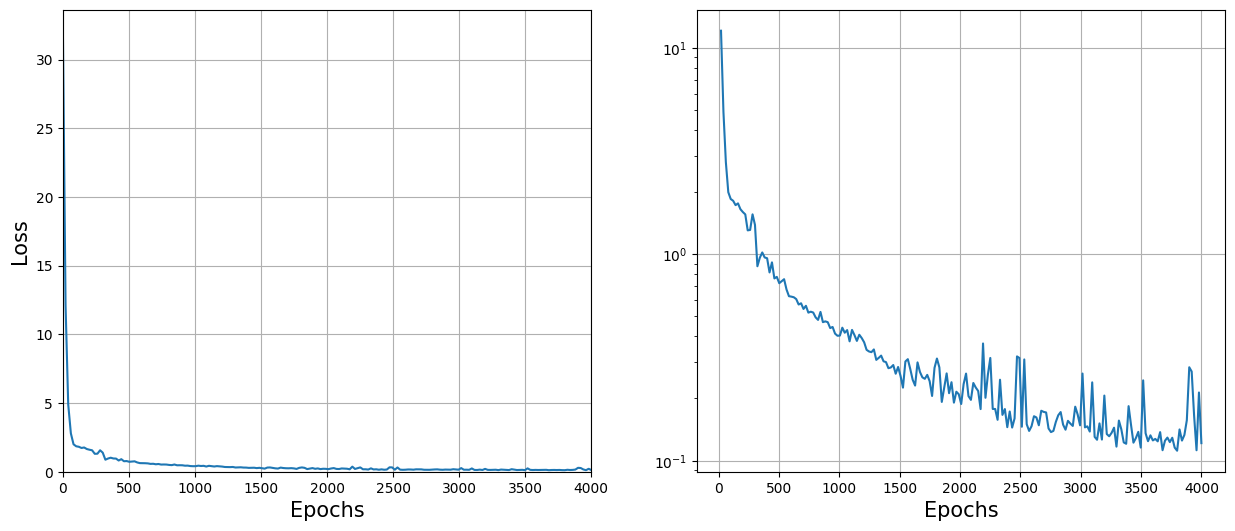

In [125]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [126]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

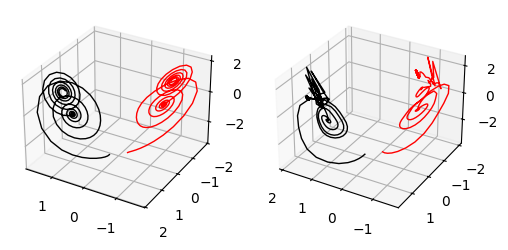

In [127]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [52]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
